In [86]:
import numpy as np
import pandas as pd
import re
from seaborn import pairplot, kdeplot, heatmap
import matplotlib.pyplot as pl
import astral

In [1]:
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
%matplotlib inline

In [36]:
with open('./nomad_seawifs_v1.3_2005262.txt') as f:
    for i, line in enumerate(f.readlines()):
        if 'fields' in line:
            col_names = line.strip('/fields=').strip().split(',')
        if '/end_header' in line:
            rowskips = i+1
            break
df = pd.read_csv('./nomad_seawifs_v1.3_2005262.txt', header=None, names=col_names, skiprows=rowskips,
                na_values=-999)

In [37]:
df.head()

,year,month,day,hour,minute,second,lat,lon,id,oisst,...,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid
0,1997,10,7,9,41,0,42.5100,39.5200,4065,19.54,...,0.00345,0.00297,0.00217,0.00026,S1997280094210.L1A_GAC,480,49.0,25.4,0.2098,0
1,1997,10,11,9,32,0,39.2900,25.1100,4069,19.57,...,0.00494,0.00348,0.00191,0.00018,S1997284110315.L1A_MLAC,5880,48.7,37.8,0.1043,1
2,1997,9,27,11,29,0,24.1392,-20.9995,6083,24.67,...,0.00625,0.00375,0.00168,0.00022,S1997270134450.L1A_MLAC,8880,28.0,35.5,0.1012,1
3,1998,5,16,8,30,0,-32.3397,17.8766,6119,17.21,...,0.00177,0.00193,0.00196,0.00055,S1998136102611.L1A_MLAC,7200,51.6,22.4,0.0940,1
4,1998,5,16,9,16,0,-32.3447,17.8735,6120,17.21,...,0.00180,0.00198,0.00199,0.00056,S1998136102611.L1A_MLAC,4440,51.6,22.4,0.0836,1


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Columns: 169 entries, year to valid
dtypes: float64(157), int64(10), object(2)
memory usage: 385.6+ KB


In [39]:
date_time_columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
df.insert(0, 'datetime', pd.to_datetime(df[date_time_columns], format='%Y-%m-%d %H:%M:%S'))

In [40]:
df.drop(date_time_columns, axis=1, inplace=True)

In [41]:
name_set = set()
matcher = re.compile('[\D]+')
for name in df.columns:
    try:
        match = matcher.findall(name)[0]
        name_set.add(match)
    except IndexError:
        continue

In [42]:
print(name_set)

{'es', 'flag', 'ag', 'sat_rrs', 'sat_file', 'cv', 'chl_a', 'wt', 'bb', 'chl', 'lw', 'senz', 'kd', 'id', 'lat', 'oisst', 'solz', 'valid', 'sal', 'cruise', 'lon', 'ap', 'datetime', 'etopo', 'ad', 'tdiff'}


In [114]:
df.filter(regex='chl', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
chl      262 non-null float64
chl_a    33 non-null float64
dtypes: float64(2)
memory usage: 4.6 KB


In [123]:
df[['wt', 'oisst']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
wt       97 non-null float64
oisst    292 non-null float64
dtypes: float64(2)
memory usage: 4.6 KB


/home/madhatter106/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/madhatter106/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


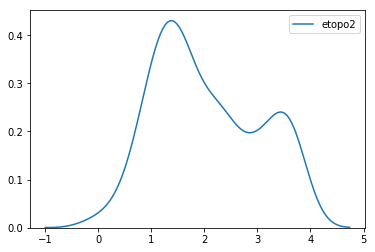

In [138]:
kdeplot(np.log10(df.etopo2));

In [155]:
df.loc[df.etopo2<=30, 'etopo2'].size / 292 * 100

32.534246575342465

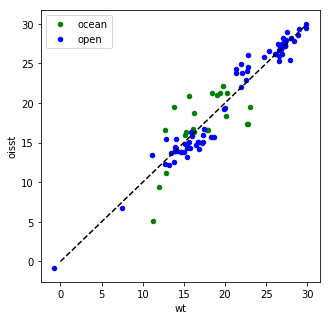

In [156]:
_, ax = pl.subplots(figsize=(5, 5))
df.loc[df.etopo2<=30, ].plot('wt', 'oisst', kind='scatter', ax=ax, color='g', label='ocean')
df.loc[df.etopo2>30, ].plot('wt', 'oisst', kind='scatter', ax=ax, color='b', label='open')
pl.plot([0, 30], [0, 30], ls='--', color='k');

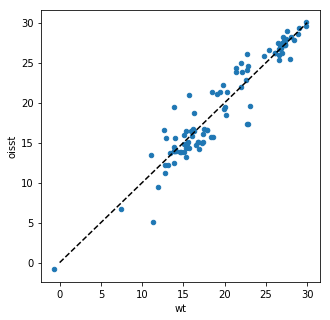

In [133]:
df.plot('wt', 'oisst', kind='scatter', figsize=(5, 5))
pl.plot([0, 30], [0, 30], ls='--', color='k');

In [72]:
def fill_chl(row):
    return row['chl_a'] if np.isfinite(row['chl_a']) else row['chl']
df['chlor_a'] = df.apply(fill_chl, axis=1)
df['is_hplc'] = np.isfinite(df['chl_a'])

In [28]:
#ooac: other optically active component (not chl)
#I: incident light field
#WS: wind speed 
#OU: non-exhaustive list of factors competing with ϕ biomass
crazy_causal_graph = CausalGraphicalModel(nodes=['sat_rrs', 'chlor_a', 'solz', 'SST', 'depth', 'senz',
                                          'light_dose', 'z_opt', 'ooac', 'I', 'MLD', 'WS', 'OU'],
                                   edges = [('chlor_a', 'sat_rrs'), ('senz', 'sat_rrs'), ('solz', 'sat_rrs'),
                                           ('oisst', 'chlor_a'), ('solz', 'chlor_a'), ('MLD', 'chlor_a'),
                                           ('depth', 'sat_rrs'), ('light_dose', 'chlor_a'),
                                           ('depth','light_dose'), ('SST', 'light_dose'), ('OU', 'chlor_a'),
                                           ('chlor_a', 'z_opt'), ('ooac', 'z_opt'), ('WS', 'MLD'),
                                           ('I', 'light_dose'), ('I', 'z_opt'), ('ooac' ,'light_dose'),
                                           ('ooac', 'sat_rrs'), ('SST', 'MLD' ), ('I', 'SST'), ('I', 'sat_rrs')])

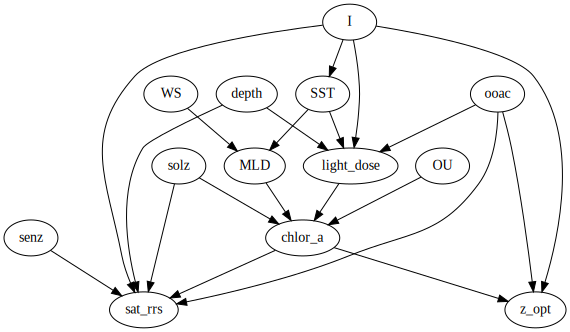

In [29]:
crazy_causal_graph.draw()

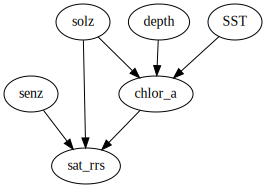

In [32]:
data_causal_graph = CausalGraphicalModel(nodes=['sat_rrs', 'chlor_a', 'solz', 'SST', 'depth', 'senz'],
                                         edges = [('chlor_a', 'sat_rrs'), ('senz', 'sat_rrs'),
                                                  ('solz', 'sat_rrs'), ('oisst', 'chlor_a'), 
                                                  ('solz', 'chlor_a'), ('depth', 'chlor_a'),
                                                  ('SST', 'chlor_a')])
data_causal_graph.draw()

In [85]:
data_causal_graph.get_all_backdoor_adjustment_sets('sat_rrs', 'chlor_a')

frozenset({frozenset({'solz'}),
           frozenset({'senz', 'solz'}),
           frozenset({'depth', 'solz'}),
           frozenset({'depth', 'senz', 'solz'}),
           frozenset({'SST', 'solz'}),
           frozenset({'SST', 'depth', 'solz'}),
           frozenset({'SST', 'senz', 'solz'}),
           frozenset({'SST', 'depth', 'senz', 'solz'})})

In [66]:
def Daylight(row):
    l = astral.Location()
    l.latitude = row['lat']
    l.longitude = row['lon']
    try:
        td = l.sunset(date=row['datetime']) - l.sunrise(date=row['datetime'])
        return td.seconds
    except:
        return np.NaN

In [67]:
df['daylength'] = df.apply(Daylight, axis=1)

In [68]:
df[['daylength']].describe()

,daylength
count,291.000000
mean,45397.288660
std,5622.147367
min,37580.000000
25%,41882.000000
50%,43700.000000
75%,49240.500000
max,70301.000000


In [70]:
df[['daylength']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 1 columns):
daylength    291 non-null float64
dtypes: float64(1)
memory usage: 2.4 KB


In [83]:
40000/3600

11.11111111111111

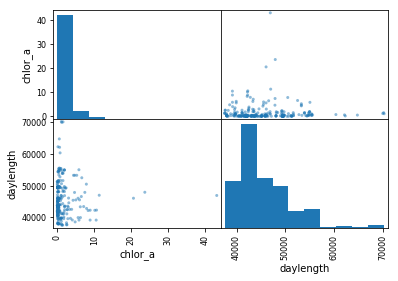

In [74]:
pd.plotting.scatter_matrix(df[['chlor_a', 'daylength']]);

In [80]:
cols_s = ['chlor_a', 'daylength']
df_s = (np.log10(df[cols_s]) - np.log10(df[cols_s].mean(axis=0))) / np.log10(df[cols_s].std(axis=0))

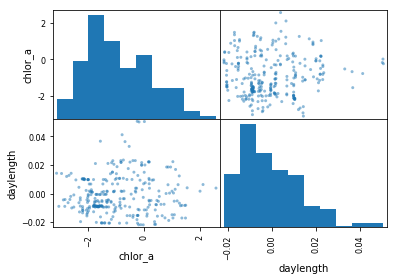

In [82]:
pd.plotting.scatter_matrix(df_s);

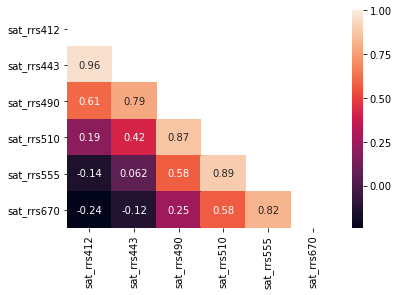

In [90]:

heatmap(df.filter(regex='sat_rrs').corr(), annot=True, mask=np.triu(np.ones((6,6))))